In [8]:
#Constructing a wide and deep neural network, which connects part of the input layers directly to output layer.
#Built using Keras functional API.

from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import Model

In [37]:
housing = fetch_california_housing()

#Split data to get training and test set 
X_train_full, X_test, y_train_full, y_test = train_test_split(housing.data, housing.target)

#Further split X_train_full and y_train_full into training and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full)

#Scale all the datasets
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)

#Some more splitting to fit things for the wide and deep network
X_train_A, X_train_B = X_train[:, :5], X_train[:, 2:]
X_valid_A, X_valid_B = X_valid[:, :5], X_valid[:, 2:]
X_test_A, X_test_B = X_test[:, :5], X_test[:, 2:]
X_new_A, X_new_B = X_test_A[:3], X_test_B[:3]

In [38]:
#Create two Input objects that specifies the input the model will get. The first input layer will take features 0 to 4 
#through the wide path. The second input layer sends features 2 to 7 through the deep path.
input_1 = keras.Input(shape=[5], name="wide_input")
input_2 = keras.Input(shape=[6], name="deep_input")
#Dense layer with 30 neurons. Uses Rectified Linear Unit activation function. 
hidden1 = keras.layers.Dense(30, activation="relu")(input_2)
#Another, second dense layer with 30 neurons that takes the outputs from hidden1.
hidden2 = keras.layers.Dense(30, activation="relu")(hidden1)
#Create a Concatenate layer which puts together the input and the output of the second hidden layer.
concat = keras.layers.Concatenate()([input_1, hidden2])
#Create an output layer with a single neuron and no activation function.
outputs = keras.layers.Dense(1, name="output")(concat)
model = keras.Model(inputs=[input_1, input_2], outputs=outputs)

In [44]:
model.compile(loss="mse", optimizer=keras.optimizers.SGD(lr=1e-3))

history = model.fit((X_train_A, X_train_B), y_train, epochs = 30, validation_data=((X_valid_A, X_valid_B), y_valid))

Epoch 1/30
363/363 [==============================] - 1s 2ms/step - loss: 0.4558 - val_loss: 0.4569
Epoch 2/30
363/363 [==============================] - 1s 1ms/step - loss: 0.4530 - val_loss: 0.4568
Epoch 3/30
363/363 [==============================] - 0s 1ms/step - loss: 0.4511 - val_loss: 0.4543
Epoch 4/30
363/363 [==============================] - 1s 2ms/step - loss: 0.4492 - val_loss: 0.4506
Epoch 5/30
363/363 [==============================] - 0s 1ms/step - loss: 0.4473 - val_loss: 0.4492
Epoch 6/30
363/363 [==============================] - 1s 2ms/step - loss: 0.4447 - val_loss: 0.4480
Epoch 7/30
363/363 [==============================] - 1s 2ms/step - loss: 0.4426 - val_loss: 0.4461
Epoch 8/30
363/363 [==============================] - 1s 2ms/step - loss: 0.4410 - val_loss: 0.4453
Epoch 9/30
363/363 [==============================] - 1s 1ms/step - loss: 0.4395 - val_loss: 0.4456
Epoch 10/30
363/363 [==============================] - 1s 2ms/step - loss: 0.4370 - val_loss: 0.4437

In [45]:
mse_test = model.evaluate((X_test_A, X_test_B), y_test)
y_pred = model.predict((X_new_A, X_new_B))

162/162 [==============================] - 0s 818us/step - loss: 0.3950


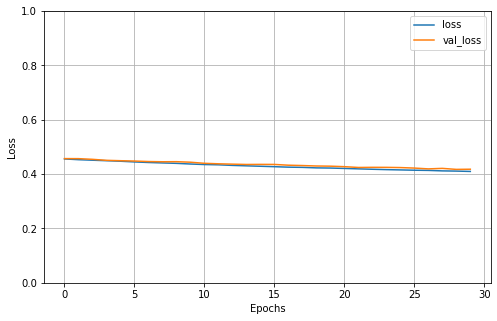

In [46]:
import pandas as pd
import matplotlib.pyplot as plt

pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

In [43]:
model.summary()

Model: "model_10"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
deep_input (InputLayer)         [(None, 6)]          0                                            
__________________________________________________________________________________________________
dense_49 (Dense)                (None, 30)           210         deep_input[0][0]                 
__________________________________________________________________________________________________
wide_input (InputLayer)         [(None, 5)]          0                                            
__________________________________________________________________________________________________
dense_50 (Dense)                (None, 30)           930         dense_49[0][0]                   
___________________________________________________________________________________________